# Sine Model Development
This is project to develop a sine estimation model for arduino uno. The model would be convert to a c header file. 

## Importing the necessary libraries

In [1]:
import torch
from torch import nn
from torchinfo import summary
import numpy as np
import struct
import matplotlib .pyplot as plt

from os import path
from tqdm.auto import tqdm

/home/matthias/Documents/EmbeddedAI/dlai/examples/sine_model/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining constants

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NO_SAMPLES = 1_000
LUCKY_NUMBER = 25
PI = 3.14159265359

TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.2

## Generating the dataset
The data will contain numbers between 0 and 2pi, the sine function will be defined in rad.
A random uniform error is added to the sine values to give the dataset a bit of variability and see how the model will perform.
The error is centred with a mean of 0 and std 0f 0.1. This is chosen such that 95% of the error is -0.25 and 0.+25.

In [3]:
np.random.seed(LUCKY_NUMBER)
torch.manual_seed(LUCKY_NUMBER)
torch.random.manual_seed(LUCKY_NUMBER)

In [4]:
x = np.random.uniform(size=NO_SAMPLES, low=0, high=2*PI)
y = np.sin(x) + np.random.normal(loc=0, scale=.125, size=NO_SAMPLES)
x.shape, y.shape

((1000,), (1000,))

## Understanding the Dataset

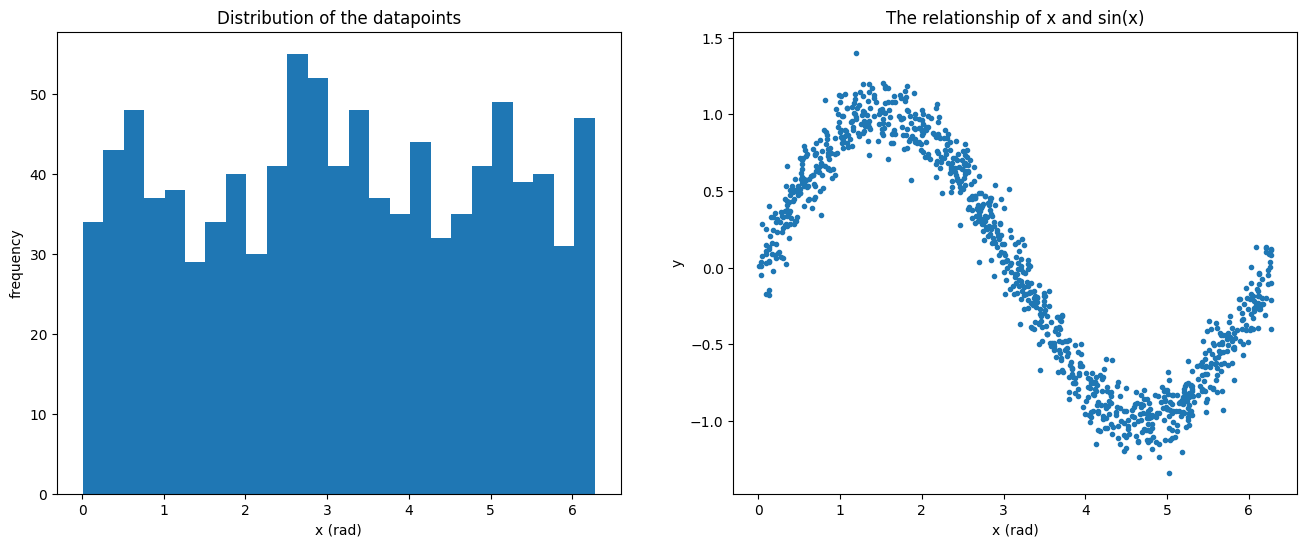

In [5]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6))

axes[0].hist(x, bins=25)
axes[0].set_ylabel("frequency")
axes[0].set_xlabel("x (rad)")
axes[0].set_title("Distribution of the datapoints")

axes[1].scatter(x, y, marker=".")
axes[1].set_ylabel("y")
axes[1].set_xlabel("x (rad)")
axes[1].set_title("The relationship of x and sin(x)")

plt.show()

## Preparing the Dataset

In [6]:
x_train, x_validate, x_test = np.array_split(x, [int(NO_SAMPLES*TRAIN_RATIO), int(NO_SAMPLES*(1-TEST_RATIO))])
y_train, y_validate, y_test = np.array_split(y, [int(NO_SAMPLES*TRAIN_RATIO), int(NO_SAMPLES*(1-TEST_RATIO))])

x_train.shape, x_validate.shape, x_test.shape, y_train.shape, y_validate.shape, y_test.shape

((700,), (100,), (200,), (700,), (100,), (200,))

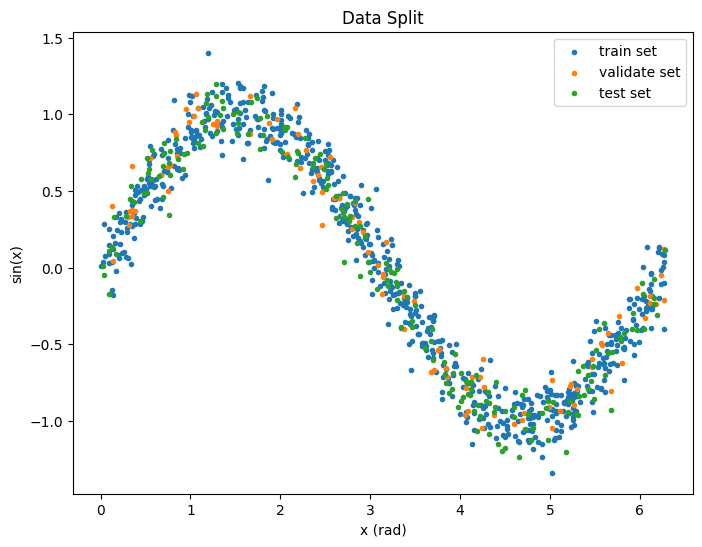

In [7]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.scatter(x_train, y_train, marker=".", label="train set")
ax.scatter(x_validate, y_validate, marker=".", label="validate set")
ax.scatter(x_test, y_test, marker=".", label="test set")
ax.set_xlabel("x (rad)")
ax.set_ylabel("sin(x)")
ax.set_title("Data Split")

ax.legend()


## Defining the model

In [8]:
class DLAI_Sequential(nn.Sequential):

    # Layer type identifiers
    LINEAR_LAYER_TYPE = 0
    RELU_LAYER = 1


    def __init__(self, *args):
        super(DLAI_Sequential, self).__init__(*args)
        

    def fit(self, X_train, y_train, loss, optimizer="adam", epoches=10, batch_size=1, validation_set=None):
        history = dict()

        loss_fn = nn.MSELoss() if loss == "mse" else None

        optimizer_fn = torch.optim.Adam(self.parameters(), lr=1e-2) if optimizer == "adam" else None

        for epoch in tqdm(range(epoches)):
            
            self.train()
            y_train_pred = self(X_train)

            optimizer_fn.zero_grad()
            
            train_loss = loss_fn(y_train, y_train_pred)
            train_loss.backward()
            optimizer_fn.step()

            history["train_loss"] = history.get("train_loss", []) + [train_loss.item()]

            if validation_set:
                X_validate = validation_set[0]
                y_validate = validation_set[1]

                self.eval()
                with torch.inference_mode():
                    y_validate_pred = self(X_validate)
                validate_loss = loss_fn(y_validate, y_validate_pred)

                history["validate_loss"] = history.get("validate_loss", []) + [validate_loss.item()]

                print(f"epoch {epoch}: training loss {train_loss:.4f} | validation loss {validate_loss:.4f}")
            else:
                print(f"epoch {epoch}: training loss {train_loss:.4f}")
        
        
        return history
    
    # ------------------------------------------------------------------------------
    # @brief Converts a float32 value to a list of 4 bytes in little-endian format.
    # @param val Float value to convert.
    # @return List of 4 bytes representing the float.
    # ------------------------------------------------------------------------------
    def float32_to_bytes(val):
        return list(struct.pack("<f", val))  # Little endian float32

    # ------------------------------------------------------------------------------
    # @brief Converts an int32 value to a list of 4 bytes in little-endian format.
    # @param val Integer value to convert.
    # @return List of 4 bytes representing the integer.
    # ------------------------------------------------------------------------------
    def int32_to_bytes(val):
        return list(struct.pack("<i", val))  # Little endian int32
    
    # ------------------------------------------------------------------------------
    # @brief Returns the maximum workspace arena size.
    # @param model Keras model (not yet used here).
    # @return Integer size of the workspace arena (default: 1024).
    # ------------------------------------------------------------------------------
    def get_max_workspace_arena(self, input_shape, device="cpu"):
        # To be implemented: dynamic calculation based on 
        max_output = 0
        
        x = torch.randn(input_shape).to(device)
        for layer in self:
            x = layer(x)
            max_output = max(max_output, x.numel())
        return max_output

    def convert_to_c(self, input_shape, model_name, dir=".", device="cpu"):
        c_array = f"#ifndef {model_name.upper()}_H\n#define {model_name.upper()}_H\n\nunsigned char {model_name.lower()}[] = {{\n"
    

        model_len = len(self)

        c_array += "    // Number of Layers\n"
        c_array += "    " + ", ".join([f"0x{b:02X}" for b in DLAI_Sequential.int32_to_bytes(model_len)]) + ",\n"

        # Add max workspace arena
        max_workspace_arena = self.get_max_workspace_arena(input_shape, device)
        c_array += "    // Max workspace arena\n"
        c_array += "    " + ", ".join([f"0x{b:02X}" for b in DLAI_Sequential.int32_to_bytes(max_workspace_arena)]) + ",\n"

        # Encode each layer
        for i, layer in enumerate(self):
            if isinstance(layer, nn.Linear):
                weight = layer.weight.cpu().detach().numpy()
                bias = layer.bias.cpu().detach().numpy()

                output_size, input_size = weight.shape

                model_type = DLAI_Sequential.LINEAR_LAYER_TYPE

                c_array += "\n    // Layer Type: Linear Layer\n"
                c_array += "    " + ", ".join([f"0x{b:02X}" for b in DLAI_Sequential.int32_to_bytes(model_type)]) + ",\n"

                c_array += "    // Output size and Input size\n"
                c_array += "    " + ", ".join([f"0x{b:02X}" for b in (
                   DLAI_Sequential.int32_to_bytes(output_size) + DLAI_Sequential.int32_to_bytes(input_size)
                )]) + ",\n"

                section = max(len(weight.flatten()) // 4, 1)

                c_array += "    // Weight\n"
                for line in np.array_split(weight.flatten(), section):
                    c_array += "    " + ", ".join(
                        [f"0x{b:02X}" for val in line for b in DLAI_Sequential.float32_to_bytes(val)]
                    ) + ",\n"

                section = max(len(bias.flatten()) // 4, 1)

                c_array += "    // Bias\n"
                for line in np.array_split(bias.flatten(), section):
                    c_array += "    " + ", ".join(
                        [f"0x{b:02X}" for val in line for b in DLAI_Sequential.float32_to_bytes(val)]
                    ) + ",\n"

            elif isinstance(layer, nn.ReLU):
                model_type = DLAI_Sequential.RELU_LAYER
                input_layer_shape = self[i-1].bias.cpu().detach().numpy().shape

                input_dim = len(input_layer_shape)
                
                input_size = 1
                for dim in range(input_dim):
                    input_size *= input_layer_shape[dim]

                c_array += "\n    // Layer Type: ReLU Activation\n"
                c_array += "    " + ", ".join(
                    [f"0x{b:02X}" for b in DLAI_Sequential.int32_to_bytes(model_type)]
                ) + ",\n"

                c_array += "    // Input dimensions and shape\n"
                c_array += "    " + ", ".join(
                    [f"0x{b:02X}" for b in (
                        DLAI_Sequential.int32_to_bytes(input_dim) + DLAI_Sequential.int32_to_bytes(input_size)
                    )]
                ) + ",\n"

        c_array += f"}};\n\nunsigned int {model_name.lower()}_len = sizeof({model_name.lower()});\n\n#endif // {model_name.upper()}_H\n"

        with open(path.join(dir, f"{model_name}.h"), "w") as file:
            file.write(c_array)

In [9]:
def fit(model, X_train, y_train, loss, optimizer="adam", epoches=10, batch_size=1, validation_set=None):
    history = dict()

    loss_fn = nn.MSELoss() if loss == "mse" else None

    optimizer_fn = torch.optim.Adam(model.parameters(), lr=1e-2) if optimizer == "adam" else None

    for epoch in tqdm(range(epoches)):
        
        model.train()
        y_train_pred = model(X_train)

        optimizer_fn.zero_grad()
        
        train_loss = loss_fn(y_train, y_train_pred)
        train_loss.backward()
        optimizer_fn.step()

        history["train_loss"] = history.get("train_loss", []) + [train_loss.item()]

        if validation_set:
            X_validate = validation_set[0]
            y_validate = validation_set[1]

            model.eval()
            with torch.inference_mode():
                y_validate_pred = model(X_validate)
            validate_loss = loss_fn(y_validate, y_validate_pred)

            history["validate_loss"] = history.get("validate_loss", []) + [validate_loss.item()]

            print(f"epoch {epoch}: training loss {train_loss:.4f} | validation loss {validate_loss:.4f}")
        else:
            print(f"epoch {epoch}: training loss {train_loss:.4f}")
    
    
    return history


In [10]:
sine_model_dlai = nn.Sequential(
    nn.Linear(in_features=1, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1)
).to(DEVICE)

In [11]:
summary(sine_model_dlai, input_size=(1,1), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Linear: 1-1                            [1, 32]                   64
├─ReLU: 1-2                              [1, 32]                   --
├─Linear: 1-3                            [1, 16]                   528
├─ReLU: 1-4                              [1, 16]                   --
├─Linear: 1-5                            [1, 1]                    17
Total params: 609
Trainable params: 609
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [12]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)

history = fit(sine_model_dlai, x_train_tensor, y_train_tensor, "mse", optimizer="adam", epoches=1000, validation_set=(x_validate_tensor, y_validate_tensor))

  7%|▋         | 71/1000 [00:00<00:02, 403.87it/s]

epoch 0: training loss 0.4938 | validation loss 0.4516
epoch 1: training loss 0.4555 | validation loss 0.4289
epoch 2: training loss 0.4297 | validation loss 0.3783
epoch 3: training loss 0.3889 | validation loss 0.3468
epoch 4: training loss 0.3664 | validation loss 0.3203
epoch 5: training loss 0.3426 | validation loss 0.2865
epoch 6: training loss 0.3066 | validation loss 0.2576
epoch 7: training loss 0.2743 | validation loss 0.2352
epoch 8: training loss 0.2472 | validation loss 0.2110
epoch 9: training loss 0.2212 | validation loss 0.1849
epoch 10: training loss 0.1968 | validation loss 0.1726
epoch 11: training loss 0.1873 | validation loss 0.1665
epoch 12: training loss 0.1763 | validation loss 0.1730
epoch 13: training loss 0.1734 | validation loss 0.1747
epoch 14: training loss 0.1728 | validation loss 0.1698
epoch 15: training loss 0.1721 | validation loss 0.1686
epoch 16: training loss 0.1704 | validation loss 0.1695
epoch 17: training loss 0.1654 | validation loss 0.1670
ep

 24%|██▎       | 236/1000 [00:00<00:01, 685.95it/s]

epoch 144: training loss 0.0279 | validation loss 0.0265
epoch 145: training loss 0.0282 | validation loss 0.0298
epoch 146: training loss 0.0283 | validation loss 0.0258
epoch 147: training loss 0.0276 | validation loss 0.0270
epoch 148: training loss 0.0265 | validation loss 0.0262
epoch 149: training loss 0.0261 | validation loss 0.0249
epoch 150: training loss 0.0261 | validation loss 0.0275
epoch 151: training loss 0.0262 | validation loss 0.0244
epoch 152: training loss 0.0257 | validation loss 0.0259
epoch 153: training loss 0.0250 | validation loss 0.0241
epoch 154: training loss 0.0244 | validation loss 0.0239
epoch 155: training loss 0.0241 | validation loss 0.0249
epoch 156: training loss 0.0240 | validation loss 0.0231
epoch 157: training loss 0.0240 | validation loss 0.0254
epoch 158: training loss 0.0239 | validation loss 0.0226
epoch 159: training loss 0.0237 | validation loss 0.0249
epoch 160: training loss 0.0234 | validation loss 0.0222
epoch 161: training loss 0.0230

 39%|███▉      | 394/1000 [00:00<00:00, 751.61it/s]

epoch 300: training loss 0.0156 | validation loss 0.0167
epoch 301: training loss 0.0163 | validation loss 0.0182
epoch 302: training loss 0.0170 | validation loss 0.0166
epoch 303: training loss 0.0162 | validation loss 0.0163
epoch 304: training loss 0.0156 | validation loss 0.0173
epoch 305: training loss 0.0162 | validation loss 0.0169
epoch 306: training loss 0.0165 | validation loss 0.0168
epoch 307: training loss 0.0158 | validation loss 0.0165
epoch 308: training loss 0.0156 | validation loss 0.0167
epoch 309: training loss 0.0161 | validation loss 0.0172
epoch 310: training loss 0.0161 | validation loss 0.0163
epoch 311: training loss 0.0156 | validation loss 0.0163
epoch 312: training loss 0.0156 | validation loss 0.0170
epoch 313: training loss 0.0159 | validation loss 0.0165
epoch 314: training loss 0.0159 | validation loss 0.0165
epoch 315: training loss 0.0156 | validation loss 0.0165
epoch 316: training loss 0.0156 | validation loss 0.0164
epoch 317: training loss 0.0158

 56%|█████▌    | 559/1000 [00:00<00:00, 768.22it/s]

epoch 475: training loss 0.0154 | validation loss 0.0164
epoch 476: training loss 0.0155 | validation loss 0.0167
epoch 477: training loss 0.0155 | validation loss 0.0164
epoch 478: training loss 0.0154 | validation loss 0.0164
epoch 479: training loss 0.0154 | validation loss 0.0167
epoch 480: training loss 0.0155 | validation loss 0.0164
epoch 481: training loss 0.0154 | validation loss 0.0165
epoch 482: training loss 0.0153 | validation loss 0.0165
epoch 483: training loss 0.0154 | validation loss 0.0164
epoch 484: training loss 0.0154 | validation loss 0.0165
epoch 485: training loss 0.0154 | validation loss 0.0164
epoch 486: training loss 0.0153 | validation loss 0.0164
epoch 487: training loss 0.0154 | validation loss 0.0165
epoch 488: training loss 0.0154 | validation loss 0.0164
epoch 489: training loss 0.0154 | validation loss 0.0164
epoch 490: training loss 0.0153 | validation loss 0.0165
epoch 491: training loss 0.0154 | validation loss 0.0164
epoch 492: training loss 0.0154

 71%|███████▏  | 713/1000 [00:01<00:00, 755.45it/s]

epoch 624: training loss 0.0153 | validation loss 0.0165
epoch 625: training loss 0.0153 | validation loss 0.0166
epoch 626: training loss 0.0153 | validation loss 0.0165
epoch 627: training loss 0.0153 | validation loss 0.0165
epoch 628: training loss 0.0153 | validation loss 0.0165
epoch 629: training loss 0.0153 | validation loss 0.0166
epoch 630: training loss 0.0153 | validation loss 0.0165
epoch 631: training loss 0.0153 | validation loss 0.0166
epoch 632: training loss 0.0153 | validation loss 0.0165
epoch 633: training loss 0.0153 | validation loss 0.0166
epoch 634: training loss 0.0153 | validation loss 0.0165
epoch 635: training loss 0.0153 | validation loss 0.0166
epoch 636: training loss 0.0153 | validation loss 0.0165
epoch 637: training loss 0.0153 | validation loss 0.0166
epoch 638: training loss 0.0153 | validation loss 0.0165
epoch 639: training loss 0.0153 | validation loss 0.0167
epoch 640: training loss 0.0154 | validation loss 0.0165
epoch 641: training loss 0.0154

 86%|████████▋ | 864/1000 [00:01<00:00, 727.37it/s]

epoch 772: training loss 0.0153 | validation loss 0.0165
epoch 773: training loss 0.0154 | validation loss 0.0168
epoch 774: training loss 0.0154 | validation loss 0.0166
epoch 775: training loss 0.0154 | validation loss 0.0169
epoch 776: training loss 0.0155 | validation loss 0.0166
epoch 777: training loss 0.0155 | validation loss 0.0168
epoch 778: training loss 0.0154 | validation loss 0.0165
epoch 779: training loss 0.0154 | validation loss 0.0167
epoch 780: training loss 0.0154 | validation loss 0.0165
epoch 781: training loss 0.0153 | validation loss 0.0166
epoch 782: training loss 0.0153 | validation loss 0.0165
epoch 783: training loss 0.0153 | validation loss 0.0166
epoch 784: training loss 0.0153 | validation loss 0.0166
epoch 785: training loss 0.0153 | validation loss 0.0165
epoch 786: training loss 0.0153 | validation loss 0.0167
epoch 787: training loss 0.0153 | validation loss 0.0166
epoch 788: training loss 0.0153 | validation loss 0.0167
epoch 789: training loss 0.0154

100%|██████████| 1000/1000 [00:01<00:00, 707.45it/s]

epoch 913: training loss 0.0155 | validation loss 0.0167
epoch 914: training loss 0.0156 | validation loss 0.0172
epoch 915: training loss 0.0157 | validation loss 0.0169
epoch 916: training loss 0.0158 | validation loss 0.0176
epoch 917: training loss 0.0160 | validation loss 0.0172
epoch 918: training loss 0.0163 | validation loss 0.0181
epoch 919: training loss 0.0166 | validation loss 0.0178
epoch 920: training loss 0.0169 | validation loss 0.0190
epoch 921: training loss 0.0174 | validation loss 0.0185
epoch 922: training loss 0.0178 | validation loss 0.0201
epoch 923: training loss 0.0183 | validation loss 0.0193
epoch 924: training loss 0.0187 | validation loss 0.0207
epoch 925: training loss 0.0189 | validation loss 0.0192
epoch 926: training loss 0.0186 | validation loss 0.0196
epoch 927: training loss 0.0180 | validation loss 0.0178
epoch 928: training loss 0.0170 | validation loss 0.0176
epoch 929: training loss 0.0161 | validation loss 0.0166
epoch 930: training loss 0.0155

Text(0.5, 1.0, 'Model loss')

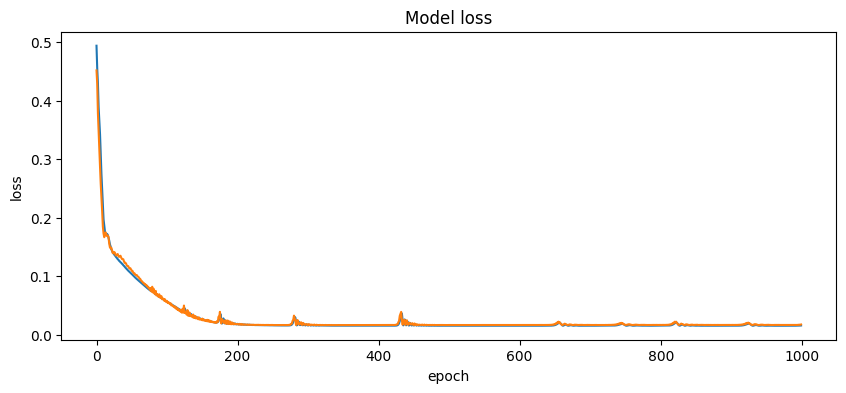

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.plot(history["train_loss"])
ax.plot(history["validate_loss"])
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Model loss")

## Testing the model

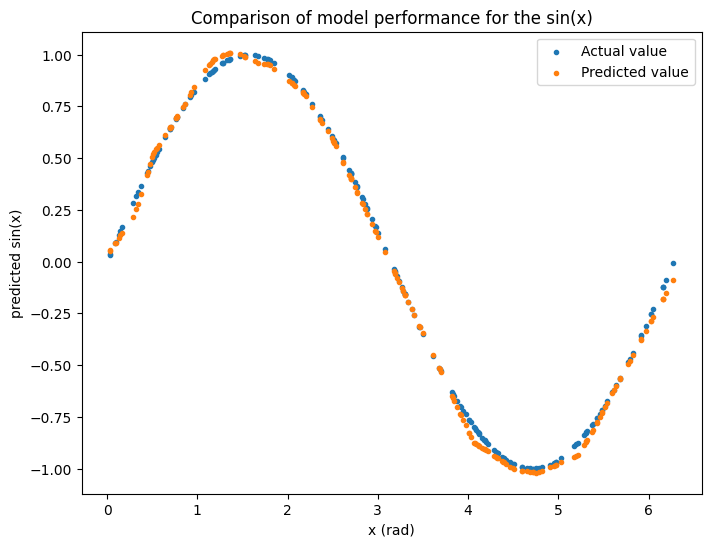

In [14]:
y_test_pred = sine_model_dlai(x_test_tensor).squeeze(dim=1).cpu().detach().numpy()

fig, ax = plt.subplots(1, figsize=(8,6))
ax.scatter(x_test, np.sin(x_test), marker=".", label="Actual value")
ax.scatter(x_test, y_test_pred, marker=".", label="Predicted value")
ax.set_xlabel("x (rad)")
ax.set_ylabel("predicted sin(x)")
ax.set_title("Comparison of model performance for the sin(x)")
ax.legend()

In [15]:
for i in range(0, 360, 10):
    print(sine_model_dlai(torch.tensor([i*2*3.141/360]).to(DEVICE)))

tensor([0.0330], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1428], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.2887], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.5321], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.6472], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.7683], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9044], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9867], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.0154], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9812], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9560], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9072], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.8439], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.7524], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.6297], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.4792], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.3157], device='cuda:0', grad_fn=<ViewBackward0

## Saving the trained sine model

In [16]:
torch.save(sine_model_dlai, "sine_model.pth")
